# Airline Price Optimization
Kaggle released an interesting [optimization challenge](https://www.kaggle.com/general/62469) about a year ago. It follows:

> You are selling airline tickets over a limited number of days. You know that demand follows a uniform distribution between `[100, 200]`. 

> <b>Objective:</b> Maximize revenue from airline ticket sales knowing available tickets for sale (`tickets_left`), days until departure (`days_left`), and daily demand (`demand_level`).

> <b>Constraints:</b>
* You only have `days_left` to sell `tickets_left`
* You cannot sell more tickets than `ticets_left`

In [1]:
# ignore this cell
from IPython.display import display, Javascript
import json
from numpy.random import uniform, seed
from numpy import floor
from collections import namedtuple
import sys

def _tickets_sold(p, demand_level, max_qty):
        quantity_demanded = floor(max(0, p - demand_level))
        return min(quantity_demanded, max_qty)

def simulate_revenue(days_left, tickets_left, pricing_function, rev_to_date=0, demand_level_min=100, demand_level_max=200, verbose=False):
    if (days_left == 0) or (tickets_left == 0):
        if verbose:
            if (days_left == 0):
                print("The flight took off today. ")
            if (tickets_left == 0):
                print("This flight is booked full.")
            print("Total Revenue: ${:.0f}".format(rev_to_date))
        return rev_to_date
    else:
        demand_level = uniform(demand_level_min, demand_level_max)
        p = pricing_function(days_left, tickets_left, demand_level)
        q = _tickets_sold(demand_level, p, tickets_left)
        if verbose:
            print("{:.0f} days before flight: "
                  "Started with {:.0f} seats. "
                  "Demand level: {:.0f}. "
                  "Price set to ${:.0f}. "
                  "Sold {:.0f} tickets. "
                  "Daily revenue is {:.0f}. Total revenue-to-date is {:.0f}. "
                  "{:.0f} seats remaining".format(days_left, tickets_left, demand_level, p, q, p*q, p*q+rev_to_date, tickets_left-q))
        return simulate_revenue(days_left = days_left-1,
                              tickets_left = tickets_left-q,
                              pricing_function=pricing_function,
                              rev_to_date=rev_to_date + p * q,
                              demand_level_min=demand_level_min,
                              demand_level_max=demand_level_max,
                              verbose=verbose)

def _save_score(score):
    message = {
        'jupyterEvent': 'custom.exercise_interaction',
        'data': {
            'learnTutorialId': 117,
            'interactionType': "check",
            'questionId': 'Aug31OptimizationChallenge',
            'outcomeType': 'Pass',
            'valueTowardsCompletion': score/10000,
            'failureMessage': None,
            'learnToolsVersion': "Testing"
        }
    }
    js = 'parent.postMessage(%s, "*")' % json.dumps(message)
    display(Javascript(js))

def score_me(pricing_function, sims_per_scenario=200):
    seed(0)
    Scenario = namedtuple('Scenario', 'n_days n_tickets')
    scenarios = [Scenario(n_days=100, n_tickets=100),
                 Scenario(n_days=14, n_tickets=50),
                 Scenario(n_days=2, n_tickets=20),
                Scenario(n_days=1, n_tickets=3),
                 ]
    scenario_scores = []
    for s in scenarios:
        scenario_score = sum(simulate_revenue(s.n_days, s.n_tickets, pricing_function)
                                     for _ in range(sims_per_scenario)) / sims_per_scenario
        print("Ran {:.0f} flights starting {:.0f} days before flight with {:.0f} tickets. "
              "Average revenue: ${:.0f}".format(sims_per_scenario,
                                                s.n_days,
                                                s.n_tickets,
                                                scenario_score))
        scenario_scores.append(scenario_score)
    score = sum(scenario_scores) / len(scenario_scores)
    try:
        _save_score(score)
    except:
        pass
    print("Average revenue across all flights is ${:.0f}".format(score))

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

## Prelimanaries: Combinatorics
Before getting started, I want to have an idea of the search space for this problem. How many ways can I sell `tickets_left` over `days_left`? Let's say I have `5` tickets, and `2` days to sell them. The different permutations to do this are:
* (0, 5) — i.e. sell 0 on `day 1`, and sell 5 on `day 2`
* (5, 0)
* (1, 4)
* (4, 1)
* (3, 2)
* (2, 3)

That gives me `6` ways to get to `5`. Cool, but is there a generic solution for this? I can frame this as a combinatorics problem where I'm looking for all the ways in which we can split `tickets_left` with `days_left - 1` dividers. 

Imagine the problem as a row of `5` one's. 
`11111`

I can then split it into `2` groups by adding a divider somewhere along that row.<br>
`|1111` (0, 5)<br>
`1|1111` (1, 4)<br>
`11|111` (2, 3)<br>
`111|11` (3, 2)<br>
$\dots$

From this point of view, the problem becomes: how many ways can I order `ticket_left` + `days_left - 1`, or $n + k$, items. We can find that with the following formula:

$f(n, k) = \frac{(n+k)!}{n!k!}$

Let's verify!

In [267]:
import numpy as np

def f(n, k): return np.math.factorial(n+k) // (np.math.factorial(n) * np.math.factorial(k))

def combos(n):
    """
    find all the combinations for 2 days
    """
    combos = 0
    items = set(range(n+1))
    for i in range(n+1):
        if (n - i) in items:
            combos += 1
    return combos

for i in range(5, 20):
    assert combos(i) == f(i, 1)

So if we have `50` tickets and `7` days to sell them, it means there are $\frac{(56)!}{50!6!} = 32,468,436$ ways to do so!

## Baseline
The baseline model provided by `Kaggle` sells `10` tickets every day. 

In [4]:
%%time
def pricing_function(days_left, tickets_left, demand_level):
    return demand_level - 10
score_me(pricing_function, sims_per_scenario=1000)

Ran 1000 flights starting 100 days before flight with 100 tickets. Average revenue: $13965
Ran 1000 flights starting 14 days before flight with 50 tickets. Average revenue: $6953
Ran 1000 flights starting 2 days before flight with 20 tickets. Average revenue: $2791
Ran 1000 flights starting 1 days before flight with 3 tickets. Average revenue: $420


<IPython.core.display.Javascript object>

Average revenue across all flights is $6032
CPU times: user 73.4 ms, sys: 12.8 ms, total: 86.3 ms
Wall time: 76.9 ms


---
## Method 0: Random
What if we just randomly chose the price?

In [269]:
%%time
def pricing_function(days_left, tickets_left, demand_level):
    n_tickets = np.random.randint(0, tickets_left)
    return demand_level - n_tickets  
score_me(pricing_function, sims_per_scenario=1000)

Ran 1000 flights starting 100 days before flight with 100 tickets. Average revenue: $9873
Ran 1000 flights starting 14 days before flight with 50 tickets. Average revenue: $6116
Ran 1000 flights starting 2 days before flight with 20 tickets. Average revenue: $1968
Ran 1000 flights starting 1 days before flight with 3 tickets. Average revenue: $151


<IPython.core.display.Javascript object>

Average revenue across all flights is $4527
CPU times: user 723 ms, sys: 14.1 ms, total: 737 ms
Wall time: 731 ms


Naturally, that is a bad approach. 

---
##  Method 1: Heuristics

Sell whatever the average number of tickets left is.

In [6]:
%%time
def pricing_function(days_left, tickets_left, demand_level):
    return demand_level - tickets_left // days_left
score_me(pricing_function, sims_per_scenario=1000)

Ran 1000 flights starting 100 days before flight with 100 tickets. Average revenue: $14895
Ran 1000 flights starting 14 days before flight with 50 tickets. Average revenue: $7343
Ran 1000 flights starting 2 days before flight with 20 tickets. Average revenue: $2810
Ran 1000 flights starting 1 days before flight with 3 tickets. Average revenue: $439


<IPython.core.display.Javascript object>

Average revenue across all flights is $6372
CPU times: user 515 ms, sys: 9 ms, total: 524 ms
Wall time: 518 ms


This method isn't as fast as the baseline, but it made us an extra `$340` on average!

What if we took that a step further and only sold the average number of tickets left, when the demand is over 150?

In [7]:
%%time
def pricing_function(days_left, tickets_left, demand_level):
    if days_left == 1:
        return demand_level - tickets_left
    if demand_level >= 150:
        n_tickets =  tickets_left // days_left
    else:
        n_tickets = 0
    return demand_level - n_tickets

score_me(pricing_function, sims_per_scenario=1000)

Ran 1000 flights starting 100 days before flight with 100 tickets. Average revenue: $16595
Ran 1000 flights starting 14 days before flight with 50 tickets. Average revenue: $7875
Ran 1000 flights starting 2 days before flight with 20 tickets. Average revenue: $2841
Ran 1000 flights starting 1 days before flight with 3 tickets. Average revenue: $439


<IPython.core.display.Javascript object>

Average revenue across all flights is $6937
CPU times: user 496 ms, sys: 10.6 ms, total: 507 ms
Wall time: 501 ms


Now we've made `$905` above the baseline!

---
## Method 2: Heuristics + Probability

What if we know the chance that the demand level will go up, or down in the future? That should impact the number of tickets sold on a single day.  

We know from the problem statement that the demand level follows a `uniform distribution` between `100` and `200`. By calculating the inverse `CDF` of the `Uniform distribution` we can determine the chance that the next day we'll get a higher demand level. We can then use the `CDF` of the `Binomial distribution`, to calculate the chance that we'll see at least one day with a higher `demand_level` over `days_left`.

In [8]:
%%time 
import scipy as sp
import scipy.stats    
import scipy.special

def pmf(n, k, p):
    """
    pmf of binomial distribution
    """
    return sp.special.comb(n, k) * (p ** k) * (1 - p) ** (n - k)

def cdf(n, k, p):
    """
    cdf of biomial distribution
    """
    return sum([pmf(n, i, p) for i in range(0, k+1)])

def chance_of_higher_demand_tomorrow(demand_level):
    """
    inverse cdf of uniform distritbuion
    """
    mn, mx = 100, 200
    return 1 - (demand_level - mn) / (mx - mn)

def pricing_function(days_left, tickets_left, demand_level):
    p = chance_of_higher_demand_tomorrow(demand_level)    
    chance_of_higher_demand = 1 - cdf(days_left, 1, p) # chance of having at least one success over {days_left} with prob {p}
    
    if days_left == 1:
        n_tickets = tickets_left
    elif chance_of_higher_demand <= 0.95:
        n_tickets = tickets_left // days_left + ((1 - chance_of_higher_demand) / 3) * tickets_left

    else:
        n_tickets = 0
    return demand_level - n_tickets

score_me(pricing_function, sims_per_scenario=1000)

Ran 1000 flights starting 100 days before flight with 100 tickets. Average revenue: $17723
Ran 1000 flights starting 14 days before flight with 50 tickets. Average revenue: $8321
Ran 1000 flights starting 2 days before flight with 20 tickets. Average revenue: $2826
Ran 1000 flights starting 1 days before flight with 3 tickets. Average revenue: $439


<IPython.core.display.Javascript object>

Average revenue across all flights is $7327
CPU times: user 2.48 s, sys: 83.4 ms, total: 2.57 s
Wall time: 2.52 s


Instead of being lead by averages, here we're actually computing the likelihood that we'll get a higher demand in the future. This leads to a `$1,295` increase from the baseline! 


---
## Method 3: Dynamic Programming
This is the provided solution from `kaggle`. By using `dynamic programming`, we start off with a small problem and then expand to a larger one. In our case, the approach is to start from `days_left - 1` and work backwards, day by day. As we move backwards, we update two variables:
* `V` — The `value function` tells us what the best outcome is from any given state.
* `Q` — The `Q function` is like the `value function` but includes the choice of tickets to sell on each day. 

In [36]:
%%time
n_demand_levels = 11
min_demand_level = 100
max_demand_level = 200
demand_levels = np.linspace(min_demand_level, max_demand_level, n_demand_levels)

max_tickets = 200
max_days = 150
# Q indices are: n_sold in day, tickets_left to start day, demand_level, days_left
Q = np.zeros([max_tickets, max_tickets, n_demand_levels, max_days])
# V indices are: n_left and n_days
V = np.zeros([max_tickets, max_days]) # value function

for days_left in range(max_days):
    for tickets_left in range(max_tickets):
        for tickets_sold in range(tickets_left+1): # allow selling all tickets
            for demand_index, demand_level in enumerate(demand_levels):
                price = max(demand_level - tickets_sold, 0)
                rev_today = price * tickets_sold
                Q[tickets_sold, tickets_left, demand_index, days_left] = rev_today + V[tickets_left-tickets_sold, days_left-1]
        # For each demand_level, choose the optimum number to sell. Output of this is an array of size n_demand_levels
        expected_total_rev_from_best_quantity_at_each_demand_level = Q[:, tickets_left, :, days_left].max(axis=0)
        # take the average, since we don't know demand level ahead of time and all are equally likely
        V[tickets_left, days_left] = expected_total_rev_from_best_quantity_at_each_demand_level.mean()

CPU times: user 1min 16s, sys: 394 ms, total: 1min 16s
Wall time: 1min 16s


In [37]:
def pricing_function(days_left, tickets_left, demand_level):
    # demand_levels contains `n_demand_levels` evenly spaced between `min_demand_level` and `max_demand_level`
    demand_level_index = np.abs(demand_level - demand_levels).argmin()
    
    day_index = days_left - 1 # arrays are 0 indexed
    tickets_index = int(tickets_left)  # in case it comes in as float, but need to index with it
    # Q indices are: n_sold in day, tickets_left to start day, demand_level, days_left
    relevant_Q_vals = Q[:, tickets_index, demand_level_index, day_index]
    desired_quantity = relevant_Q_vals.argmax() # offset 0 indexing
    price = demand_level - desired_quantity
    return price

score_me(pricing_function, sims_per_scenario=1000)

Ran 1000 flights starting 100 days before flight with 100 tickets. Average revenue: $18451
Ran 1000 flights starting 14 days before flight with 50 tickets. Average revenue: $8480
Ran 1000 flights starting 2 days before flight with 20 tickets. Average revenue: $2929
Ran 1000 flights starting 1 days before flight with 3 tickets. Average revenue: $444


<IPython.core.display.Javascript object>

Average revenue across all flights is $7576


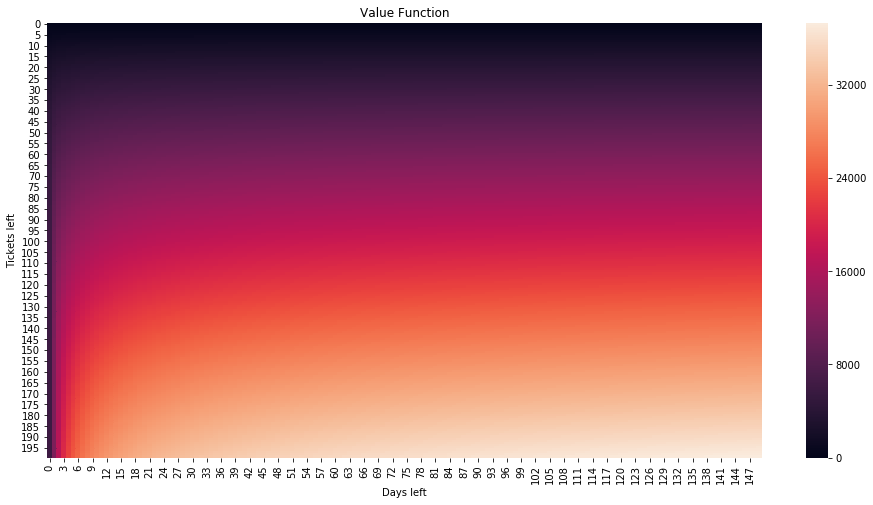

In [39]:
plt.figure(figsize=(16, 8))
sns.heatmap(V);
plt.xlabel("Days left"); plt.ylabel("Tickets left"); plt.title("Value Function");

---
## Method 4: MDP
This is a work in progress. At the moment, it is the same as the above approach but introduces a discount factor. 

In [272]:
class MDP():
    
    def __init__(self, max_tickets, max_days):
        self.max_tickets = max_tickets
        self.max_days = max_days
        self.min_demand_level, self.max_demand_level, self.n_demand_levels = 100, 200, 11
        self.demand_levels = np.linspace(self.min_demand_level, self.max_demand_level, self.n_demand_levels)
        self.Q = np.zeros([self.max_tickets, self.max_tickets, self.n_demand_levels, self.max_days]) 
        self.V = np.zeros([self.max_tickets, self.max_days])      
        # index: tickets n_sold in day, tickets_left to start day, demand_level, days_left

    def expected_utility(self, tickets_left, days_left, gamma):
        for tickets_sold in range(tickets_left+1):
            for demand_index, demand_level in enumerate(demand_levels):
                price = max(demand_level - tickets_sold, 0)
                rev_today = price * tickets_sold
                
                self.Q[tickets_sold, tickets_left, demand_index, days_left] = rev_today + gamma * self.V[tickets_left-tickets_sold, days_left-1]
        
    def value_iteration(self, gamma):
        for days_left in range(self.max_days):
            for tickets_left in range(self.max_tickets):
                u = self.expected_utility(tickets_left, days_left, gamma)
                expected_total_rev_from_best_quantity_at_each_demand_level = self.Q[:, tickets_left, :, days_left].max(axis=0)
                self.V[tickets_left, days_left] = expected_total_rev_from_best_quantity_at_each_demand_level.mean()

        return self.V, self.Q
    
max_tickets = 200
max_days = 150
mdp = MDP(max_tickets, max_days)
vi_V, vi_Q = mdp.value_iteration(0.98)

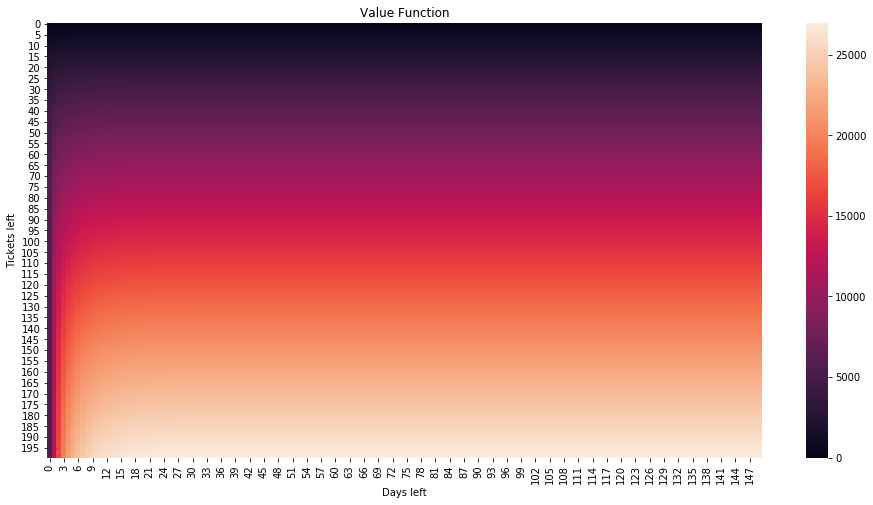

In [273]:
plt.figure(figsize=(16, 8))
sns.heatmap(vi_V);
plt.xlabel("Days left"); plt.ylabel("Tickets left"); plt.title("Value Function");

In [274]:
def pricing_function(days_left, tickets_left, demand_level):
    # demand_levels contains `n_demand_levels` evenly spaced between `min_demand_level` and `max_demand_level`
    demand_level_index = np.abs(demand_level - demand_levels).argmin()
    
    day_index = days_left - 1 # arrays are 0 indexed
    tickets_index = int(tickets_left)  # in case it comes in as float, but need to index with it
    relevant_Q_vals = vi_Q[:, tickets_index, demand_level_index, day_index]
    desired_quantity = relevant_Q_vals.argmax() # offset 0 indexing
    price = demand_level - desired_quantity
    return price

score_me(pricing_function, sims_per_scenario=1000)

Ran 1000 flights starting 100 days before flight with 100 tickets. Average revenue: $16430
Ran 1000 flights starting 14 days before flight with 50 tickets. Average revenue: $8358
Ran 1000 flights starting 2 days before flight with 20 tickets. Average revenue: $2889
Ran 1000 flights starting 1 days before flight with 3 tickets. Average revenue: $440


<IPython.core.display.Javascript object>

Average revenue across all flights is $7029
